# Ответы на вопросы по изображениям (VQA)
## 1. Strong baseline: LSTM + ResNet152 + Attention (2017)

*  Выделить признаки изображения
*  Выделить признаки вопроса
*  Передать полученные вектора в модель
*  Определить лучший ответ с помощью softmax'а

### Скачиваем обученную VQA модель и веса

In [ ]:
# После установки следует перезапустить runtime
!pip install -U 'Pillow==5.2.0'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os, sys

from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=UserWarning) # Cleaner demos : Don't do this normally...

In [ ]:
if not os.path.isfile('./pytorch-vqa/README.md'):
    !git clone https://github.com/Cyanogenoid/pytorch-vqa.git
sys.path.append(os.path.realpath('./pytorch-vqa'))

In [ ]:
# https://github.com/Cyanogenoid/pytorch-vqa/releases

if not os.path.isfile('./2017-08-04_00.55.19.pth'):   # 81Mb model
    !wget https://github.com/Cyanogenoid/pytorch-vqa/releases/download/v1.0/2017-08-04_00.55.19.pth

In [ ]:
try: 
    import torch
except:
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    accelerator = 'cu80' if os.path.exists('/opt/bin/nvidia-smi') else 'cpu'
    !pip install -q \
      http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl \
      torchvision

In [ ]:
import torch

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
import model # from pytorch-vqa

#saved_state = torch.load('logs/2017-08-04_00:55:19.pth')
saved_state = torch.load('./2017-08-04_00.55.19.pth', map_location=device)
tokens = len(saved_state['vocab']['question']) + 1

saved_state.keys()  # See what's in the saved state

dict_keys(['name', 'tracker', 'config', 'weights', 'eval', 'vocab'])

### A Strong Baseline For Visual Question Answering
Сссылка на статью https://arxiv.org/pdf/1704.03162.pdf 
![Модель](https://i.ibb.co/4TNZFH3/image.png)

In [ ]:
# Load the predefined model
vqa_net = torch.nn.DataParallel(model.Net(tokens))
vqa_net.load_state_dict(saved_state['weights'])
vqa_net.to(device)
vqa_net.eval()

DataParallel(
  (module): Net(
    (text): TextProcessor(
      (embedding): Embedding(15193, 300, padding_idx=0)
      (drop): Dropout(p=0.5, inplace=False)
      (tanh): Tanh()
      (lstm): LSTM(300, 1024)
    )
    (attention): Attention(
      (v_conv): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (q_lin): Linear(in_features=1024, out_features=512, bias=True)
      (x_conv): Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1))
      (drop): Dropout(p=0.5, inplace=False)
      (relu): ReLU(inplace=True)
    )
    (classifier): Classifier(
      (drop1): Dropout(p=0.5, inplace=False)
      (lin1): Linear(in_features=5120, out_features=1024, bias=True)
      (relu): ReLU()
      (drop2): Dropout(p=0.5, inplace=False)
      (lin2): Linear(in_features=1024, out_features=3000, bias=True)
    )
  )
)

* Обработка текста
* Механизм внимания
* Классификатор


### Теперь найдем нейросеть для выделения признаков изображения
Это будет Resnet152!

![Resnet](https://pytorch.org/assets/images/resnet.png)

In [ ]:
if not os.path.isfile('./pytorch-resnet/README.md'):
    !git clone https://github.com/Cyanogenoid/pytorch-resnet.git
sys.path.append(os.path.realpath('./pytorch-resnet'))

In [ ]:
import resnet  # from pytorch-resnet

import torchvision.transforms as transforms
from PIL import Image

def get_transform(target_size, central_fraction=1.0):
    return transforms.Compose([
        transforms.Resize(int(target_size / central_fraction)),
        transforms.CenterCrop(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

class ResNetLayer4(torch.nn.Module):
    def __init__(self):
        super(ResNetLayer4, self).__init__()
        self.model = resnet.resnet152(pretrained=True)
        
        # from  visual_qa_analysis/config.py
        image_size = 448  # scale shorter end of image to this size and centre crop
        #output_size = image_size // 32  # size of the feature maps after processing through a network
        output_features = 2048  # number of feature maps thereof
        central_fraction = 0.875 # only take this much of the centre when scaling and centre cropping

        self.transform = get_transform(image_size, central_fraction)

        def save_output(module, input, output):
            self.buffer = output
        self.model.layer4.register_forward_hook(save_output)

    def forward(self, x):
        self.model(x)
        return self.buffer
    
    def image_to_features(self, img_file):
        img = Image.open(img_file).convert('RGB')
        img_transformed = self.transform(img)
        #print(img_transformed.size())
        img_batch = img_transformed.unsqueeze(0).to(device)
        return self.forward(img_batch) 
    
resnet_layer4 = ResNetLayer4().to(device)  # Downloads 241Mb model when first run
resnet_layer4

Downloading: "https://github.com/Cyanogenoid/pytorch-resnet/releases/download/hosting/resnet152-95e0e999.pth" to /root/.cache/torch/hub/checkpoints/resnet152-95e0e999.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

ResNetLayer4(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

#### Register forward hook
https://web.stanford.edu/~nanbhas/blog/forward-hooks-pytorch/

In [ ]:
# Sample images : 
image_urls, image_path, image_files = [
    'https://upload.wikimedia.org/wikipedia/commons/3/38/Adorable-animal-cat-20787.jpg',
    'https://imgc.allpostersimages.com/img/print/posters/cat-black-jumping-off-wall_a-G-12469828-14258383.jpg',
    'https://i.ytimg.com/vi/AIwlyly7Eso/hqdefault.jpg',
    'https://upload.wikimedia.org/wikipedia/commons/9/9b/Black_pussy_-_panoramio.jpg',
    'https://www.thehappycatsite.com/wp-content/uploads/2017/06/siamese5.jpg',
    'https://c.pxhere.com/photos/15/e5/cat_roof_home_architecture_building_roofs_animal_sit-536976.jpg!d',
    'https://upload.wikimedia.org/wikipedia/commons/thumb/a/a3/June_odd-eyed-cat.jpg/737px-June_odd-eyed-cat.jpg',
], './img/', []
os.makedirs('./img', exist_ok=True)
for url in image_urls:
    image_file=os.path.join(image_path, os.path.basename(url))
    image_files.append(image_file)
    if not os.path.isfile(image_file):
        !wget {url} --directory-prefix ./img/
image_files

--2022-07-13 18:05:39--  https://upload.wikimedia.org/wikipedia/commons/3/38/Adorable-animal-cat-20787.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1155778 (1.1M) [image/jpeg]
Saving to: ‘./img/Adorable-animal-cat-20787.jpg’

Adorable-animal-cat 100%[===================>]   1.10M  --.-KB/s    in 0.08s   

2022-07-13 18:05:39 (14.5 MB/s) - ‘./img/Adorable-animal-cat-20787.jpg’ saved [1155778/1155778]

--2022-07-13 18:05:39--  https://imgc.allpostersimages.com/img/print/posters/cat-black-jumping-off-wall_a-G-12469828-14258383.jpg
Resolving imgc.allpostersimages.com (imgc.allpostersimages.com)... 23.36.199.139
Connecting to imgc.allpostersimages.com (imgc.allpostersimages.com)|23.36.199.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13843 (14K) [image/jpeg]
Savi

['./img/Adorable-animal-cat-20787.jpg',
 './img/cat-black-jumping-off-wall_a-G-12469828-14258383.jpg',
 './img/hqdefault.jpg',
 './img/Black_pussy_-_panoramio.jpg',
 './img/siamese5.jpg',
 './img/cat_roof_home_architecture_building_roofs_animal_sit-536976.jpg!d',
 './img/737px-June_odd-eyed-cat.jpg']

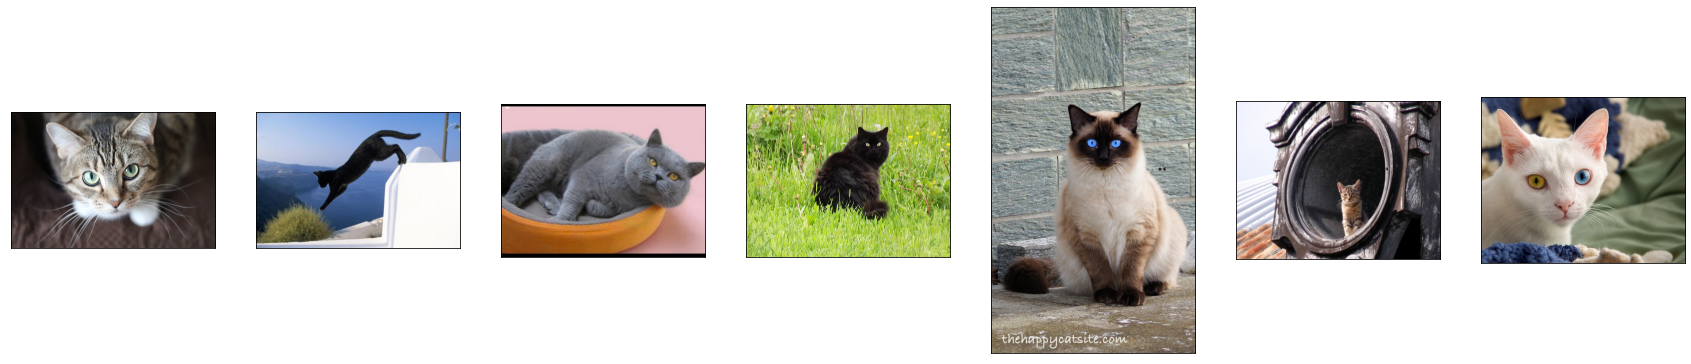

In [38]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F
from torchvision.io import read_image

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(figsize=(30, 30),ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
       
image_tensors = [read_image(image) for image in image_files]
show(image_tensors) 

In [ ]:
v = resnet_layer4.image_to_features(image_files[0])
v.size()

torch.Size([1, 2048, 14, 14])

### Немного о том, как устроен словарь

In [ ]:
vocab = saved_state['vocab']
vocab.keys()  # dict_keys(['question', 'answer'])
list(vocab['question'].items())[:5]  # [('the', 1), ('is', 2), ('what', 3), ('are', 4), ('this', 5)]

[('the', 1), ('is', 2), ('what', 3), ('are', 4), ('this', 5)]

In [ ]:
qtoken_to_index = vocab['question']
QUESTION_LENGTH_MAX = 30 # say...
    
def encode_question(question_str):
    """ Turn a question into a vector of indices and a question length """
    question_arr = question_str.lower().split(' ')
    #vec = torch.zeros(QUESTION_LENGTH_MAX).long()
    vec = torch.zeros(len(question_arr)).long()  
    for i, token in enumerate(question_arr):
        vec[i] = qtoken_to_index.get(token, 0)
    return vec.to(device), torch.tensor( len(question_arr) ).to(device)

In [ ]:
list(vocab['answer'].items())[:5]    # [('yes', 0), ('no', 1), ('2', 2), ('1', 3), ('white', 4)]

[('yes', 0), ('no', 1), ('2', 2), ('1', 3), ('white', 4)]

In [ ]:
vocab

{'answer': {'yes': 0,
  'no': 1,
  '2': 2,
  '1': 3,
  'white': 4,
  '3': 5,
  'red': 6,
  'blue': 7,
  '4': 8,
  'green': 9,
  'black': 10,
  'yellow': 11,
  'brown': 12,
  '5': 13,
  'tennis': 14,
  'baseball': 15,
  '6': 16,
  'orange': 17,
  '0': 18,
  'bathroom': 19,
  'wood': 20,
  'right': 21,
  'left': 22,
  'frisbee': 23,
  'pink': 24,
  'gray': 25,
  'pizza': 26,
  '7': 27,
  'kitchen': 28,
  '8': 29,
  'cat': 30,
  'skiing': 31,
  'skateboarding': 32,
  'dog': 33,
  'snow': 34,
  'black and white': 35,
  'skateboard': 36,
  'surfing': 37,
  'water': 38,
  'giraffe': 39,
  'grass': 40,
  'surfboard': 41,
  'wii': 42,
  'kite': 43,
  '10': 44,
  'purple': 45,
  'elephant': 46,
  'broccoli': 47,
  'man': 48,
  'winter': 49,
  'stop': 50,
  'train': 51,
  '9': 52,
  'apple': 53,
  'silver': 54,
  'horse': 55,
  'banana': 56,
  'umbrella': 57,
  'eating': 58,
  'sheep': 59,
  'bear': 60,
  'phone': 61,
  '12': 62,
  'motorcycle': 63,
  'cake': 64,
  'wine': 65,
  'beach': 66,
  '

In [ ]:
# Создаем список ответов
answer_words = ['UNDEF'] * len(vocab['answer'])
for w,idx in vocab['answer'].items():
    answer_words[idx]=w
len(answer_words), answer_words[:10]  # 3000, ['yes', 'no', '2', '1', 'white', '3', 'red', 'blue', '4', 'green']

(3000, ['yes', 'no', '2', '1', 'white', '3', 'red', 'blue', '4', 'green'])

In [ ]:
# На всякий случай
'colour' in qtoken_to_index, 'color' in qtoken_to_index, 'tabby' in answer_words

(False, True, True)

## Время экспериментов
### Протестируем одну из картинок

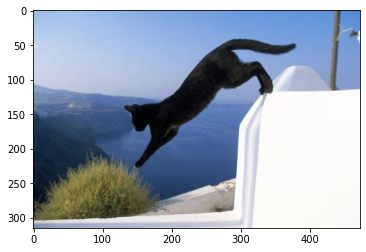

In [ ]:
image_idx = 1
image_filename = image_files[image_idx]

img = Image.open(image_filename).convert('RGB')
plt.imshow(img)

In [ ]:
# Получаем признаки изображения
v0 = resnet_layer4.image_to_features(image_filename)

In [ ]:
# Кодируем вопрос
q, q_len = encode_question("is there a cat in the picture")
#q, q_len = encode_question("what color is the cat's fur")
#q, q_len = encode_question("is the cat jumping up or down")
q, q_len

(tensor([ 2, 13,  8, 43,  6,  1, 18]), tensor(7))

In [ ]:
# Получаем ответ модели
ans = vqa_net(v0, q.unsqueeze(0), q_len.unsqueeze(0))
ans.data.cpu()[0:10]

tensor([[ -3.7204,  -4.3731, -10.6446,  ..., -30.4159, -29.2702, -25.0491]])

In [43]:
ans.shape

torch.Size([1, 3000])

In [ ]:
# В качестве ответа берем единственное слово
_, answer_idx = ans.data.cpu().max(dim=1)
answer_words[answer_idx]

'yes'

### Упростим немного

In [44]:
def vqa_single_softmax(im_features, q_str):
    # Задаем один вопрос
    q, q_len = encode_question(q_str)
    ans = vqa_net(im_features, q.unsqueeze(0), q_len.unsqueeze(0))
    return ans.data.cpu()

def vqa(image_filename, question_arr):
    # Демонстрация ответов на несколько вопросов к одному изображению
    plt.imshow(Image.open(image_filename).convert('RGB')); plt.show()    
    image_features = resnet_layer4.image_to_features(image_filename)
    for question_str in question_arr:
        _, answer_idx = vqa_single_softmax(image_features, question_str).max(dim=1)
        #print(question_str+" -> "+answer_words[ answer_idx ])
        print((answer_words[ answer_idx ]+' '*8)[:8]+" <- "+question_str)  

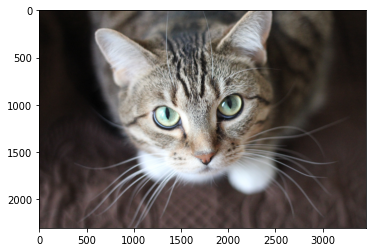

yes      <- is there a cat in the picture
no       <- is this a picture of a cat
dog      <- is the animal in the picture a cat or a dog
white    <- what color is the cat
green    <- what color are the cat's eyes


In [47]:
image_idx = 0  # 6 

vqa(image_files[image_idx], [
    "is there a cat in the picture",
    "is this a picture of a cat",
    "is the animal in the picture a cat or a dog",
    "what color is the cat",
    "what color are the cat's eyes",
])

Мы начинаем о чем то догадываться...

### Устроим модели стресс тест!

#### По очереди уберем одно слово из вопроса

In [ ]:
def leave_one_out(image_filename, question_base):
    plt.imshow(Image.open(image_filename).convert('RGB')); plt.show()    
    image_features = resnet_layer4.image_to_features(image_filename)
    question_arr = question_base.lower().split(' ')
    for i, word_omit in enumerate(question_arr):
        question_str = ' '.join( question_arr[:i]+question_arr[i+1:] )
        score, answer_idx = vqa_single_softmax(image_features, question_str).max(dim=1)
        #print(question_str+" -> "+answer_words[ answer_idx ])
        print((answer_words[ answer_idx ]+' '*8)[:8]+" <- "+question_str)  #, score

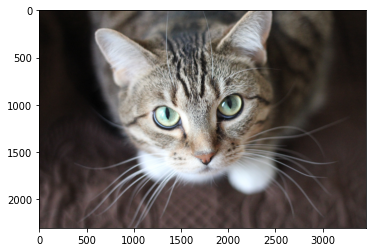

yes      <- there a cat in the picture
yes      <- is a cat in the picture
yes      <- is there cat in the picture
yes      <- is there a in the picture
yes      <- is there a cat the picture
yes      <- is there a cat in picture
yes      <- is there a cat in the


In [48]:
image_idx = 0

leave_one_out(image_files[image_idx], "is there a cat in the picture")  # mouse? dog?

#### Проверим все комбинации слов из вопроса

In [49]:
def leave_out_combos(image_filename, question_base):

    plt.imshow(Image.open(image_filename).convert('RGB')); plt.show()    
    image_features = resnet_layer4.image_to_features(image_filename)
    question_arr = question_base.lower().split(' ')
    for i in range(2 ** len(question_arr)):
        q_arr = [question_arr[j] for j in range(len(question_arr)) if (i & (2**j))==0 ]
        question_str = ' '.join( q_arr )
        _, answer_idx = vqa_single_softmax(image_features, question_str).max(dim=1)
        print((answer_words[ answer_idx ]+' '*8)[:8]+" <- "+question_str)

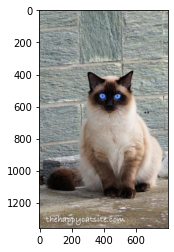

yes      <- is there a cat in the picture
yes      <- there a cat in the picture
yes      <- is a cat in the picture
no       <- a cat in the picture
yes      <- is there cat in the picture
no       <- there cat in the picture
yes      <- is cat in the picture
no       <- cat in the picture
yes      <- is there a in the picture
yes      <- there a in the picture
yes      <- is a in the picture
yes      <- a in the picture
yes      <- is there in the picture
yes      <- there in the picture
no       <- is in the picture
yes      <- in the picture
yes      <- is there a cat the picture
no       <- there a cat the picture
no       <- is a cat the picture
no       <- a cat the picture
no       <- is there cat the picture
no       <- there cat the picture
yes      <- is cat the picture
siamese  <- cat the picture
yes      <- is there a the picture
yes      <- there a the picture
yes      <- is a the picture
yes      <- a the picture
yes      <- is there the picture
yes      <- there the pic

In [50]:
image_idx = 4

leave_out_combos(image_files[image_idx], "is there a cat in the picture")
#leave_out_combos(image_files[image_idx], "what color are cat's eyes")

#### Выкинем самые неинформативные слова

In [55]:
def leave_out_best(image_filename, question_base):
    # По очереди выкидываем одно слово 
    # и смотрим какая комбинация слов даст лучший скор
    plt.imshow(Image.open(image_filename).convert('RGB')); plt.show()    
    image_features = resnet_layer4.image_to_features(image_filename)
    _, answer_true = vqa_single_softmax(image_features, question_base).max(dim=1)
    print((answer_words[ answer_true ]+' '*8)[:8]+" <- "+question_base)
    print()
    while True:
        question_arr = question_base.lower().split(' ')
        score_best, q_best = None, ''
        for i, word_omit in enumerate(question_arr):
            question_str = ' '.join( question_arr[:i]+question_arr[i+1:] )
            score, answer_idx = vqa_single_softmax(image_features, question_str).max(dim=1)
            if answer_idx==answer_true:
                print((answer_words[ answer_idx ]+' '*8)[:8]+" <- "+question_str)  #, score        
                if (score_best is None or score>score_best):
                    score_best, question_base = score, question_str
        print()
        if score_best is None or len(question_base)==0: break

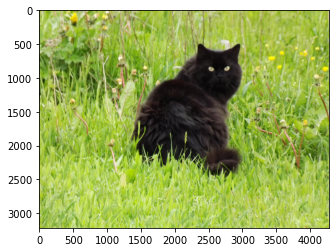

black    <- what color is the cat in the picture

black    <- color is the cat in the picture
black    <- what color the cat in the picture
black    <- what color is cat in the picture
black    <- what color is the cat the picture
black    <- what color is the cat in picture
black    <- what color is the cat in the

black    <- color is the cat in the
black    <- what color is the cat the
black    <- what color is the cat in

black    <- color is the cat the
black    <- what color the cat the
black    <- what color is cat the
black    <- what color is the cat

black    <- what color cat the
black    <- what color is cat

black    <- color cat the
black    <- what color the
black    <- what color cat

black    <- color cat




In [56]:
image_idx = 3

leave_out_best(image_files[image_idx], "what color is the cat in the picture") 
# "is there a cat in the picture"
# what color is the can in the picture  #coca cola?


# Поговорим о проблемах